In [1]:
%%capture output
! pip install ibllib
! pip install pynapple
! pip install git+https://github.com/int-brain-lab/paper-brain-wide-map.git
! pip install -U google-colab

In [2]:
# system
from pathlib import Path
from tqdm import tqdm
import pickle

# analysis
import numpy as np
import pandas as pd
import pynapple as nap

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# set the IBL style for figures
# from ibl_style.style import figure_style
# figure_style()

In [3]:
prefix = '/home/ines/repositories/'

# Load trial data

In [4]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
# states_file = pd.read_parquet(data_path+'states_trial_type_5k_5_09-24-2025')
states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')
trials_df = states_file[['mouse_name', 'session', 'correct', 'choice', 'contrast', 'reaction',
       'response', 'elongation', 'block', 'wsls', 'trial_id',
       'goCueTrigger_times']].drop_duplicates()
del states_file
trials_df = trials_df.rename(columns={'session':'eid'})

: 

In [15]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
# session_cluster = pd.read_parquet(data_path+'cluster_per_session')
trial_modes = pd.read_parquet(data_path+'5_cluster_per_trial')
trial_modes = trial_modes[['session', 'sample', 'trial_cluster']].drop_duplicates()
trial_modes['index'] = trial_modes['sample'].str.split().str[1:2].str.join('').astype(float)
trial_modes = trial_modes.rename(columns={'index':'trial_id', 'session':'eid'})

In [5]:
from reproducible_ephys_functions import get_insertions
from one.api import ONE
one= ONE()

In [6]:
insertions = get_insertions(level=0, one=one, freeze='freeze_2024_03')
repro_ephys_insertions = pd.DataFrame.from_dict(insertions)

In [7]:
repro_eid = repro_ephys_insertions['probe_insertion']

In [8]:
import brainwidemap
# this dataframe holds a summary of all the sessions
# and for us importantly, the eids and pids
bwm_df = brainwidemap.bwm_query()  # each row of this dataframe is a recording

n_sessions = bwm_df["eid"].unique().shape[0]
n_insertions = bwm_df["pid"].unique().shape[0]
print(
    f"{n_sessions} sessions with {n_insertions} individual neuropixel recordings"
)
bwm_df.head()

Loading bwm_query results from fixtures/2023_12_bwm_release.csv
459 sessions with 699 individual neuropixel recordings


,pid,eid,probe_name,session_number,date,subject,lab
0,56f2a378-78d2-4132-b3c8-8c1ba82be598,6713a4a7-faed-4df2-acab-ee4e63326f8d,probe00,1,2020-02-18,NYU-11,angelakilab
1,47be9ae4-290f-46ab-b047-952bc3a1a509,56956777-dca5-468c-87cb-78150432cc57,probe01,1,2020-02-21,NYU-11,angelakilab
2,6be21156-33b0-4f70-9a0f-65b3e3cd6d4a,56956777-dca5-468c-87cb-78150432cc57,probe00,1,2020-02-21,NYU-11,angelakilab
3,8dfb86c8-d45c-46c4-90ec-33078014d434,4364a246-f8d7-4ce7-ba23-a098104b96e4,probe01,1,2020-01-20,NYU-12,angelakilab
4,c893c0a3-5597-49cf-baa1-60efdfdef542,b182b754-3c3e-4942-8144-6ee790926b58,probe01,1,2020-01-21,NYU-12,angelakilab


## Getting units from the brainwide map

In [9]:
units_df = brainwidemap.bwm_units(one)
n_units = units_df.shape[0]
print(f"{n_units} units present in the table")
units_df.head()

Loading bwm_query results from fixtures/2023_12_bwm_release.csv
d16d0b38d392b18c0ce8b615ec89d60d7c901df2eeb3432986b62130af28ef01
62990 units present in the table


,Beryl,eid,channels,depths,uuids,cluster_id,amp_max,amp_min,amp_median,amp_std_dB,...,ks2_label,x,y,z,acronym,atlas_id,axial_um,lateral_um,pid,spike_count_good
0,AAA,37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0,61,620.0,c5cabbda-1f74-4168-ad5e-7c5a2f533d9f,79,0.000300,0.000081,0.000158,1.056608,...,good,-0.002378,-0.00025,-0.006350,CNU,23,620.0,11.0,f4ff3ff8-19b7-40c7-bf6f-8b577b811ed1,167762.0
1,AAA,37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0,68,700.0,5b5176f2-228f-46b5-85c8-205cf9d90a53,88,0.000323,0.000123,0.000221,0.972567,...,good,-0.002364,-0.00025,-0.006272,CNU,23,700.0,43.0,f4ff3ff8-19b7-40c7-bf6f-8b577b811ed1,16139.0
2,AAA,37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0,71,720.0,19930b44-2f8a-44e1-a8ce-46184f7334cb,91,0.000187,0.000057,0.000109,1.266665,...,good,-0.002364,-0.00025,-0.006252,CNU,23,720.0,27.0,f4ff3ff8-19b7-40c7-bf6f-8b577b811ed1,34700.0
3,AAA,37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0,77,780.0,304c2251-f207-4926-ba28-967ebbda4473,105,0.000208,0.000046,0.000079,1.655816,...,good,-0.002364,-0.00025,-0.006192,CNU,23,780.0,11.0,f4ff3ff8-19b7-40c7-bf6f-8b577b811ed1,224475.0
4,AAA,37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0,82,840.0,4bd714b8-5753-4561-87e5-2ef3126426b7,115,0.000346,0.000085,0.000163,1.334542,...,good,-0.002364,-0.00025,-0.006132,CNU,23,840.0,59.0,f4ff3ff8-19b7-40c7-bf6f-8b577b811ed1,292062.0


In [10]:
repro_units = units_df.loc[units_df['pid'].isin(list(repro_eid))]

## Example: loading a recording with spikes from a given brain region

Lets get a recording where the probe was inserted into our favourite brain area. The simplest way is to access the 'Beryl' column of the `units_df` dataframe and use it to select units

In [11]:
repro_units['Beryl'].unique()

array(['APN', 'CA1', 'CA3', 'DG', 'Eth', 'LD', 'LGd', 'LP', 'MG', 'MRN',
       'NOT', 'PF', 'PO', 'POL', 'POST', 'PPT', 'PoT', 'ProS', 'RN',
       'SCm', 'SGN', 'SPF', 'SSp-tr', 'SUB', 'VISa', 'VISam', 'VISp',
       'VISpm', 'VPL', 'VPLpc', 'VPM', 'VPMpc', 'ZI'], dtype=object)

In [12]:
# Here we repeat the imports and instantiate ONE, so this cell can also be run stand-alone
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage

from iblutil.numerical import bincount2D
from iblatlas.atlas import BrainRegions
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader, SessionLoader
from ibl_style.style import figure_style

figure_style()  # set the style for IBL figures

one_kwargs = dict(
    base_url='https://openalyx.internationalbrainlab.org',
    username='intbrainlab',
    password='international',
    silent=True,
)
one = ONE(**one_kwargs)

def psth_indices(times, t_events, fs=None, event_window=np.array([-1, 1])):
    """
    Compute the peri-event time indices
    :param signal:
    :param times:
    :param t_events:
    :param fs:
    :param event_window:
    :return: idx_psth: (nc, nt), tscale
    """
    event_window = np.array(event_window)
    if fs is None:
        fs = 1 / np.nanmedian(np.diff(times))
    # compute a vector of indices corresponding to the perievent window at the given sampling rate
    sample_window = np.round(
        np.arange(event_window[0] * fs, event_window[1] * fs + 1)
    ).astype(int)
    # we inflate this vector to a 2d array where each column corresponds to an event
    idx_psth = np.tile(sample_window[:, np.newaxis], (1, t_events.size))
    # we add the index of each event too their respective column
    idx_event = np.searchsorted(times, t_events)
    idx_psth += idx_event
    # here we handle the case where the event window is outside of the initial boundaries
    i_out_of_bounds = np.logical_or(idx_psth > (times.size - 1), idx_psth < 0)
    idx_psth[i_out_of_bounds] = -1
    return idx_psth, sample_window.astype(float) / fs


def compute_binned_psths(st, sc, t_events, dt=0.02, event_window=np.array([-1, 1])):
    raster, t_scale, c_scale = bincount2D(st, sc, xbin=dt)
    ipsth, tscale = psth_indices(t_scale, t_events=t_events, event_window=event_window)
    return raster[:, ipsth], tscale  # (nc, nt, ne)

def extract_perievent(raster, t_scale, t_events, event_window):
    ipsth, tscale = psth_indices(
        t_scale, t_events=t_events, event_window=event_window
    )
    return raster[:, ipsth], tscale  # (nc, nt, ne)

def compute_binned_psths_with_baseline(
    st,
    sc,
    t_events,
    t_baseline_events,
    dt=0.02,
    event_window=np.array([-1, 1]),
    baseline_window=np.array([-0.5, 0])
):
    # bin spikes
    raster, t_scale, c_scale = bincount2D(st, sc, xbin=dt)

    # PSTH aligned to main event
    psth, tscale = extract_perievent(
        raster, t_scale, t_events, event_window)  # (nc, nt, ne)

    # baseline aligned to different event
    baseline, _ = extract_perievent(
        raster, t_scale, t_baseline_events, baseline_window)  # (nc, ntb, ne_b)

    # mean baseline per neuron
    baseline_mean = np.nanmean(baseline, axis=(1, 2), keepdims=True)
    # shape: (nc, 1, 1)

    psth_bs = psth - baseline_mean

    return psth_bs, tscale


## Querying and loading the data

Then we will query the brain region ACA. ACA has many sub-regions, and we need to get the list of neurons belinging to any of the sub-regions.

In [13]:
BRAIN_REGIONS = ['PPC', 'CA1', 'DG', 'LP', 'PO']  # Reproducible ephys regions
BRAIN_REGIONS = ['VISa', 'VISam', 'CA1', 'DG', 'LP', 'PO']  # Reproducible ephys regions

regions = BrainRegions()
aca_leaf_nodes = regions.descendants(regions.acronym2id(BRAIN_REGIONS))
print(f"List of regions to query: \n {aca_leaf_nodes['acronym']}")

List of regions to query: 
 ['VISam' 'VISam1' 'VISam2/3' 'VISam4' 'VISam5' 'VISam6a' 'VISam6b' 'VISa'
 'VISa1' 'VISa2/3' 'VISa4' 'VISa5' 'VISa6a' 'VISa6b' 'CA1' 'CA1slm'
 'CA1so' 'CA1sp' 'CA1sr' 'DG' 'DG-mo' 'DG-po' 'DG-sg' 'DG-sgz' 'DGcr'
 'DGcr-mo' 'DGcr-po' 'DGcr-sg' 'DGlb' 'DGlb-mo' 'DGlb-po' 'DGlb-sg' 'DGmb'
 'DGmb-mo' 'DGmb-po' 'DGmb-sg' 'LP' 'PO']


# Process and save PETH with trial info

In [14]:
def into_df(psths, area, pid):
    n_cells = psths.shape[0]
    n_timesteps = psths.shape[1]
    n_trials = psths.shape[2]
    # reorder axes: (cell, trial, time)
    peth_reordered = np.transpose(psths, (0, 2, 1))
    # collapse cell × trial
    peth_2d = peth_reordered.reshape(n_cells * n_trials, n_timesteps)
    cell_idx = np.repeat(np.arange(n_cells), n_trials)
    trial_idx = np.tile(np.arange(n_trials), n_cells)
    df = pd.DataFrame(peth_2d)
    df["cell_id"] = cell_idx
    df['trial_id'] = trial_idx
    df['brain_region'] = area
    df['pid'] = pid
    
    return df
    

In [15]:
event_window = [-1, 1]
baseline_window = [-.3, -.1]
event_type  = 'firstMovement_times'
baseline_type = 'stimOn_times'
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

data_path = prefix + 'representation_learning_variability/Neural data/DATA/PETHS/'
# existing_files = os.listdir(data_path)
# eid_to_process = 

for p, pid in enumerate(list(repro_eid)):
    try:
        dfs = []
        for a, area in enumerate(BRAIN_REGIONS):
            aca_leaf_nodes = regions.descendants(regions.acronym2id(area))
            
            # Here we load the spikes and the trials has we have seen before. Here we load only the units passing the quality control
            ssl = SpikeSortingLoader(one=one, pid=pid)
            spikes, clusters, channels = ssl.load_spike_sorting(good_units=True, revision='2025-05-26')
            df_clus = pd.DataFrame(ssl.merge_clusters(spikes, clusters, channels))
            sl = SessionLoader(one=one, eid=ssl.eid)
            sl.load_trials()
            # For the trials, it is handy to create a column that contains the absolute contrast
            sl.trials['ucontrast'] = np.nanmean(np.stack((sl.trials['contrastLeft'], sl.trials['contrastRight'])), axis=0)

            # This is were we select the units belonging to any of the leaf nodes brain regions
            selection_clusters = df_clus['atlas_id'].isin(aca_leaf_nodes['id'])
            iclusters = np.where(selection_clusters)[0]
            # We extend the selection to the spikes that belong to the selected clusters
            ispikes = np.isin(spikes['clusters'], iclusters)
            st = spikes['times'][ispikes]
            sc = spikes['clusters'][ispikes]
            
            if len(sc)>0:
                psths, tscale = compute_binned_psths_with_baseline(st, sc, t_events=sl.trials[event_type].values, 
                                                                t_baseline_events=sl.trials[baseline_type].values, dt=0.02, 
                                                                event_window=event_window, baseline_window=baseline_window)
                
                df = into_df(psths, area, pid)
                dfs.append(df)
        
        if len(dfs)>0:
            pid_df = pd.concat(dfs, ignore_index=True)
            
            # Save this recording
            filename = data_path+pid+'_'+event_type
            pid_df.to_parquet(filename, engine="pyarrow", compression="snappy")
            del pid_df, df, dfs
    except Exception as error:
        print("An error occurred for pid: ", pid, type(error).__name__) # An error occurred: NameError
                
            

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

An error occurred for pid:  92033a0c-5a14-471b-b131-d43c72ca5d7a ALFObjectNotFound


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

An error occurred for pid:  22212d26-a167-45fb-9963-35ecd003e8a2 ALFObjectNotFound


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

An error occurred for pid:  b2746c16-7152-45a3-a7f0-477985638638 ALFObjectNotFound


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

An error occurred for pid:  31f3e083-a324-4b88-b0a4-7788ec37b191 ALFObjectNotFound


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

An error occurred for pid:  1f3d3fcb-f188-47a2-87e5-ac1db6cf393a ALFObjectNotFound


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

An error occurred for pid:  9117969a-3f0d-478b-ad75-98263e3bfacf ALFObjectNotFound


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

An error occurred for pid:  bc1602ba-dd6c-4ae4-bcb2-4925e7c8632a ALFObjectNotFound
An error occurred for pid:  7cbecb3f-6a8a-48e5-a3be-8f7a762b5a04 ALFObjectNotFound
An error occurred for pid:  17d9710a-f292-4226-b033-687d54b6545a ALFObjectNotFound


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

An error occurred for pid:  7f3dddf8-637f-47bb-a7b7-e303277b2107 ALFObjectNotFound
An error occurred for pid:  8b7c808f-763b-44c8-b273-63c6afbc6aae ALFObjectNotFound
An error occurred for pid:  e49f221d-399d-4297-bb7d-2d23cc0e4acc ALFObjectNotFound


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

An error occurred for pid:  6e1379e8-3af0-4fc5-8ba8-37d3bb02226b ALFObjectNotFound


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

An error occurred for pid:  bf96f6d6-4726-4cfa-804a-bca8f9262721 ALFObjectNotFound


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

An error occurred for pid:  19baa84c-22a5-4589-9cbd-c23f111c054c ALFObjectNotFound


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

An error occurred for pid:  84bb830f-b9ff-4e6b-9296-f458fb41d160 ALFObjectNotFound
An error occurred for pid:  ca5764ea-a57e-49de-8156-84da18ad439f ALFObjectNotFound
An error occurred for pid:  730770d6-617a-4ada-95db-a48521befda5 ALFObjectNotFound


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

An error occurred for pid:  a12c8ae8-d5ad-4d15-b805-436ad23e5ad1 ALFObjectNotFound


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

An error occurred for pid:  ae252f7b-0224-4925-8174-7b25c2385bb7 ALFObjectNotFound


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

An error occurred for pid:  dc50c3de-5d84-4408-9725-22ae55b93522 ALFObjectNotFound


/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2025-03-03"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)
/home

## Load and average per cell

In [34]:
event_type  = 'firstMovement_times'
data_path = prefix + 'representation_learning_variability/Neural data/DATA/PETHS/'
all_cells = pd.DataFrame()
for p, pid in enumerate(list(repro_eid)):
    filename = data_path+pid+'_'+event_type
    try:
        pid_df = pd.read_parquet(filename)
        cell_summary = pid_df.groupby(['cell_id', 'brain_region', 'pid']).mean().reset_index()
        all_cells = pd.concat([all_cells, cell_summary])
    except:
        print(pid)

e4ce2e94-6fb9-4afe-acbf-6f5a3498602e
b83407f8-8220-46f9-9b90-a4c9f150c572
92822789-608f-44a6-ad64-fe549402b2df
92033a0c-5a14-471b-b131-d43c72ca5d7a
22212d26-a167-45fb-9963-35ecd003e8a2
b2746c16-7152-45a3-a7f0-477985638638
478de1ce-d7e7-4221-9365-2abdc6e88fb6
31f3e083-a324-4b88-b0a4-7788ec37b191
1f3d3fcb-f188-47a2-87e5-ac1db6cf393a
9117969a-3f0d-478b-ad75-98263e3bfacf
bc1602ba-dd6c-4ae4-bcb2-4925e7c8632a
7cbecb3f-6a8a-48e5-a3be-8f7a762b5a04
17d9710a-f292-4226-b033-687d54b6545a
7f3dddf8-637f-47bb-a7b7-e303277b2107
8b7c808f-763b-44c8-b273-63c6afbc6aae
e49f221d-399d-4297-bb7d-2d23cc0e4acc
6e1379e8-3af0-4fc5-8ba8-37d3bb02226b
bf96f6d6-4726-4cfa-804a-bca8f9262721
a3d13b05-bf4d-427a-a2d5-2fe050d603ec
19baa84c-22a5-4589-9cbd-c23f111c054c
84bb830f-b9ff-4e6b-9296-f458fb41d160
ca5764ea-a57e-49de-8156-84da18ad439f
730770d6-617a-4ada-95db-a48521befda5
a12c8ae8-d5ad-4d15-b805-436ad23e5ad1
ae252f7b-0224-4925-8174-7b25c2385bb7
dc50c3de-5d84-4408-9725-22ae55b93522
1f5d62cb-814f-4ab2-b6af-7557ea04d56a
9

# PCA

In [41]:
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
from sklearn.decomposition import PCA

In [36]:
all_cells = all_cells.reset_index().reset_index()
all_cells = all_cells.rename(columns={'level_0':'unique_cell'})
all_cells = all_cells.drop(columns='index')

In [40]:
X = np.array(all_cells.drop(columns=['unique_cell', 'cell_id', 'brain_region', 'pid', 'trial_id']))

In [42]:
n_components = 100
# Step 1: Reduce dimensions with PCA
pca = PCA(n_components)  # Reduce to 50 dimensions
scaler = StandardScaler()
standardized_X = scaler.fit_transform(X)
X_pca = pca.fit_transform(standardized_X)

Text(0.5, 1.0, 'Explained Variance by PCA')

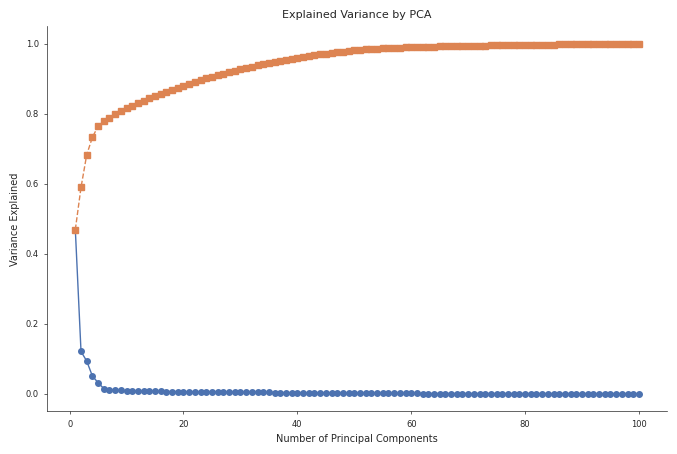

In [43]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components+1), explained_variance_ratio, marker='o', label='Individual')
plt.plot(range(1, n_components+1), cumulative_variance, marker='s', label='Cumulative', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained")
plt.title("Explained Variance by PCA")

In [1]:
metadata_df = bwm_df.copy()
metadata_df = metadata_df.rename(columns={'subject':'mouse_name'})
metadata_repro = metadata_df.loc[metadata_df['pid'].isin(repro_eid)]

merged_meta = metadata_repro.merge(mouse_cluster[['mouse_name', 'mouse_cluster']], 
                                   on='mouse_name')
to_plot = all_cells.merge(merged_meta, on='pid', how='outer')

NameError: name 'bwm_df' is not defined

(array([2814.,    0.,  434.,    0.,  218.,    0.,  240.,    0.,  375.,
          91.]),
 array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ]),
 <BarContainer object of 10 artists>)

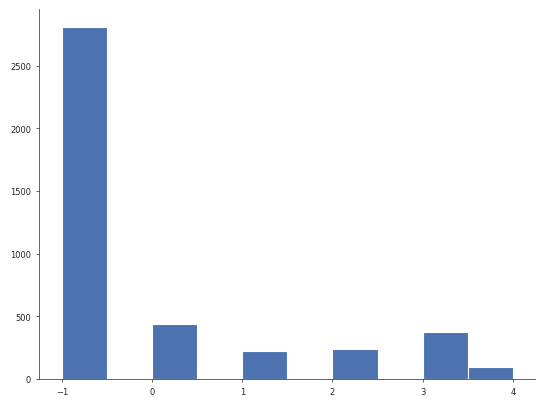

In [80]:
plt.hist(fingerprint_region_number)

(-10.0, 10.0)

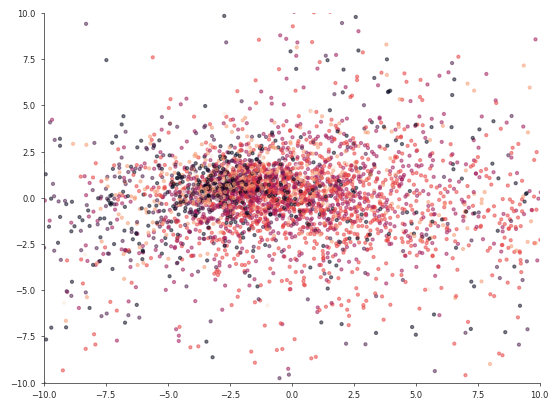

In [72]:
brain_region_number = pd.factorize(all_cells['brain_region'])[0]
fingerprint_region_number = pd.factorize(to_plot['mouse_cluster'])[0]

plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, marker='o', s=5, 
         c=brain_region_number)
plt.xlim([-10, 10])
plt.ylim([-10, 10])

# plt.scatter(X_pca[:, 1], size=1)


## Plot per area

In [17]:
# all_cells = all_cells.drop(columns='trial_id')
df_long = (all_cells.reset_index().melt(
                id_vars=["cell_id", "brain_region", "pid"],
                var_name="time",
                value_name="firing_rate"))

df_long = df_long.loc[(df_long['time']!='index') & (df_long['time']!='trial_id')]
df_long['firing_rate'] = df_long['firing_rate']/0.02
df_long.loc[df_long['brain_region']=='VISa', 'brain_region'] = 'VISa/am'
df_long.loc[df_long['brain_region']=='VISam', 'brain_region'] = 'VISa/am'

In [20]:
color_map =  {'VISa': sns.color_palette('colorblind')[0],
            'VISam': sns.color_palette('colorblind')[0],
            'VISa/am': sns.color_palette('colorblind')[0],
            'CA1': sns.color_palette('colorblind')[2],
            'DG': sns.color_palette('muted')[2],
            'LP': sns.color_palette('colorblind')[6],
            'PO': sns.color_palette('muted')[3]}
color = [sns.color_palette('colorblind')[0],
         sns.color_palette('colorblind')[0],
        sns.color_palette('colorblind')[2],
        sns.color_palette('muted')[2],
        sns.color_palette('colorblind')[6],
         sns.color_palette('muted')[3]]
color_order = ['VISa', 'VISam', 'CA1', 'DG', 'LP', 'PO']

color = [sns.color_palette('colorblind')[0],
        sns.color_palette('colorblind')[2],
        sns.color_palette('muted')[2],
        sns.color_palette('colorblind')[6],
         sns.color_palette('muted')[3]]
color_order = ['VISa/am', 'CA1', 'DG', 'LP', 'PO']

Text(0.5, 0, 'Time from movement (s)')

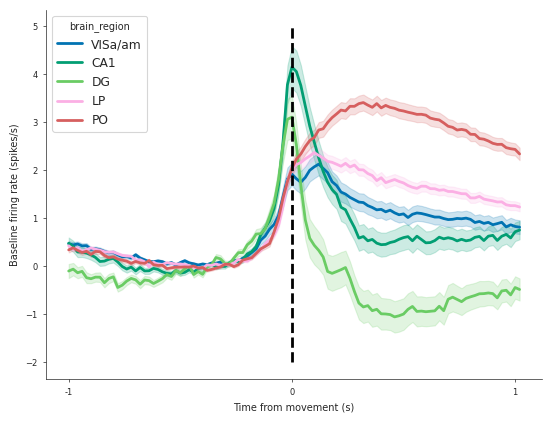

In [26]:
sns.lineplot(x='time', y='firing_rate', hue='brain_region', data=df_long, 
             palette=color, hue_order=color_order, errorbar='se', linewidth=2)
plt.vlines(50, -2, 5, color='black', linestyle='dashed', linewidth=2)
plt.xticks([0, 50, 100], [-1, 0, 1])
plt.ylabel('Baseline firing rate (spikes/s)')
plt.xlabel('Time from movement (s)')

## Behavioral fingerprint and lab

In [27]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
mouse_cluster = pd.read_parquet(data_path+'5_mouse_cluster_coef')

In [28]:
mouse_cluster['shuffled_cluster'] = np.random.permutation(mouse_cluster['mouse_cluster'].values)

In [29]:
metadata_df = bwm_df.copy()
metadata_df = metadata_df.rename(columns={'subject':'mouse_name'})
metadata_repro = metadata_df.loc[metadata_df['pid'].isin(repro_eid)]

merged_meta = metadata_repro.merge(mouse_cluster[['mouse_name', 'mouse_cluster']], 
                                   on='mouse_name')
to_plot = df_long.merge(merged_meta, on='pid')

Text(0.5, 0, 'Time from movement (s)')

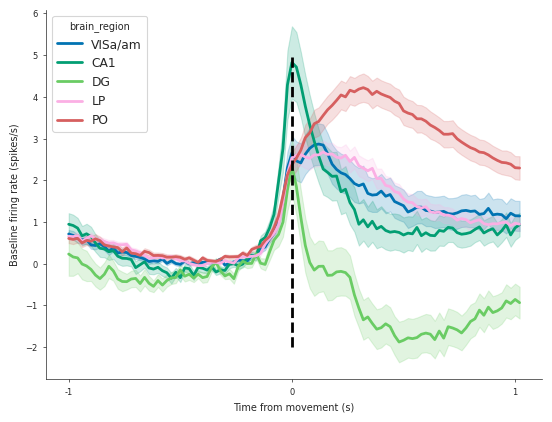

In [30]:
sns.lineplot(x='time', y='firing_rate', hue='brain_region', data=to_plot, 
             palette=color, hue_order=color_order, errorbar='se', linewidth=2)
plt.vlines(50, -2, 5, color='black', linestyle='dashed', linewidth=2)
plt.xticks([0, 50, 100], [-1, 0, 1])
plt.ylabel('Baseline firing rate (spikes/s)')
plt.xlabel('Time from movement (s)')

## Lab

Text(0.5, 0, 'Time from movement (s)')

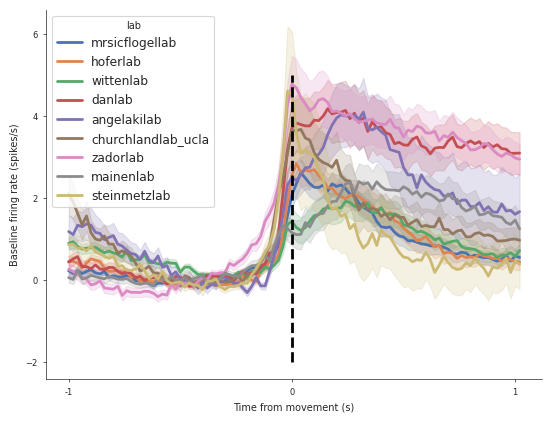

In [31]:
sns.lineplot(x='time', y='firing_rate', hue='lab', data=to_plot, 
             errorbar='se', linewidth=2)
plt.vlines(50, -2, 5, color='black', linestyle='dashed', linewidth=2)
plt.xticks([0, 50, 100], [-1, 0, 1])
plt.ylabel('Baseline firing rate (spikes/s)')
plt.xlabel('Time from movement (s)')

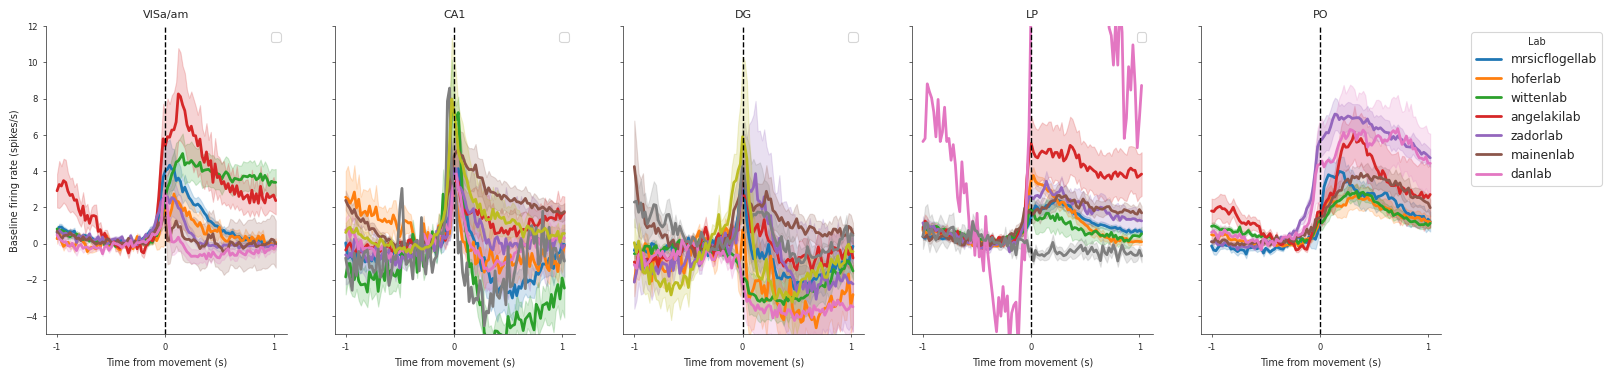

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=[18, 4])

for a, area in enumerate(color_order):
    area_to_plot = to_plot.loc[to_plot['brain_region']==area]
    sns.lineplot(x='time', y='firing_rate', hue='lab', data=area_to_plot, 
             errorbar='se', linewidth=2, palette='tab10', ax=ax[a])
    ax[a].vlines(50, -5, 12, color='black', linestyle='dashed', linewidth=1)
    ax[a].set_xticks([0, 50, 100], [-1, 0, 1])
    ax[a].set_ylabel('Baseline firing rate (spikes/s)')
    ax[a].set_xlabel('Time from movement (s)')
    ax[a].set_ylim([-5, 12])
    ax[a].set_title(area)
    ax[a].legend('')
ax[a].legend(title='Lab', loc='upper left', bbox_to_anchor=(1.1, 1))
#     ax[a].legend()
# ax[5].legend

## Mouse fingerprint

(array([ 5.,  0.,  6.,  0.,  0., 13.,  0.,  8.,  0.,  7.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

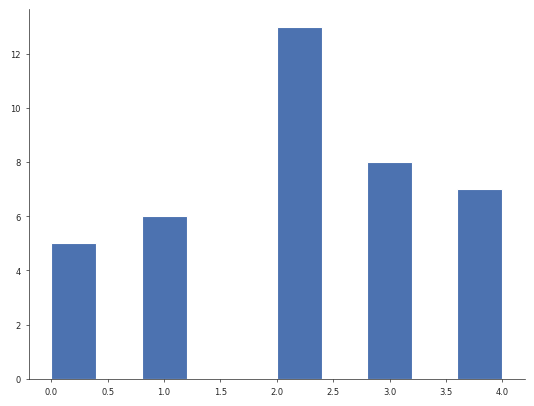

In [41]:
plt.hist(mouse_cluster['mouse_cluster'])

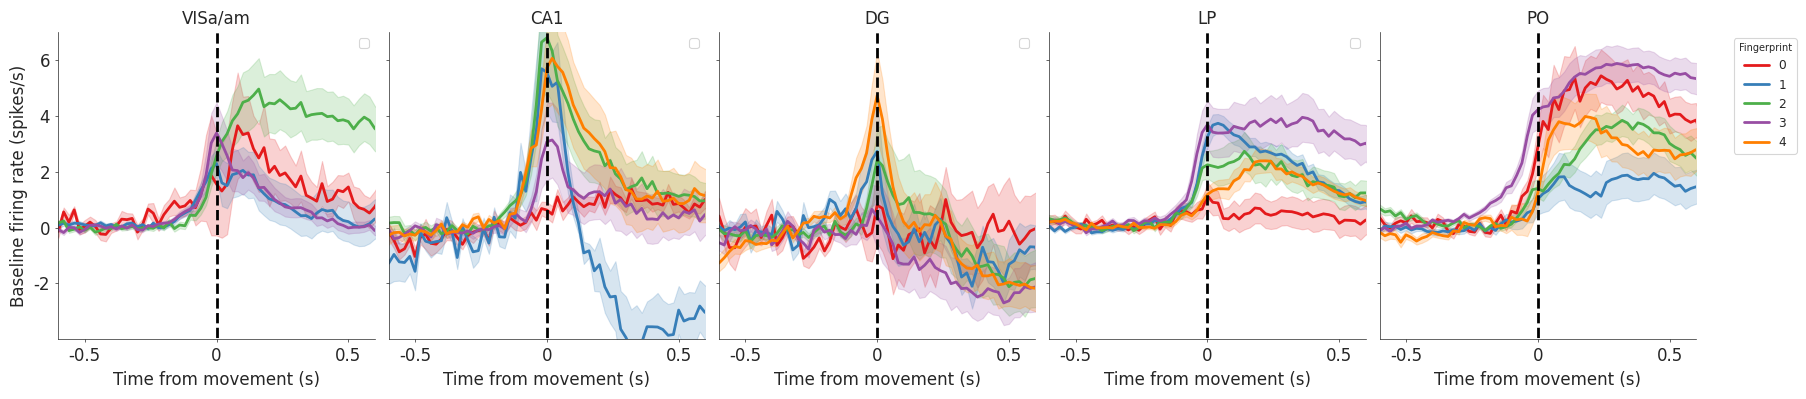

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=[18, 4])
for a, area in enumerate(color_order):
    area_to_plot = to_plot.loc[to_plot['brain_region']==area]
    sns.lineplot(x='time', y='firing_rate', hue='mouse_cluster', data=area_to_plot, 
             errorbar='se', linewidth=2, palette='Set1', ax=ax[a])
    ax[a].vlines(50, -5, 12, color='black', linestyle='dashed', linewidth=2)
    ax[a].set_xticks([0, 50, 100], [-1, 0, 1], size=12)
    ax[a].set_xticks([25, 50, 75], [-.5, 0, .5], size=12)
    ax[a].set_yticks([-2, 0, 2, 4, 6], [-2, 0, 2, 4, 6], size=12)

    ax[a].set_ylabel('Baseline firing rate (spikes/s)', size=12)
    ax[a].set_xlabel('Time from movement (s)', size=12)
    ax[a].set_ylim([-4, 7])
    ax[a].set_xlim([20, 80])
    ax[a].set_title(area, size=12)
    ax[a].legend('')
ax[a].legend(title='Fingerprint', loc='upper left', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
#     ax[a].legend()
# ax[5].legend

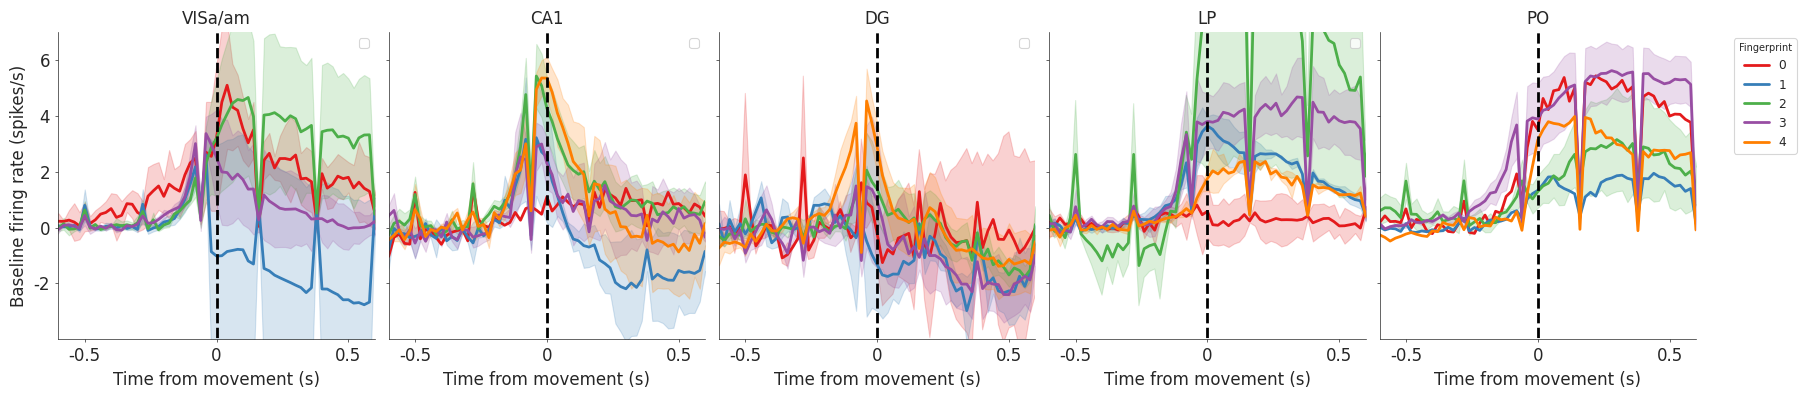

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=[18, 4])
for a, area in enumerate(color_order):
    area_to_plot = to_plot.loc[to_plot['brain_region']==area]
    area_to_plot = area_to_plot.groupby(['time', 'brain_region', 'pid', 'mouse_cluster'])['firing_rate'].apply(lambda x: np.nanmean(x)).reset_index()
    sns.lineplot(x='time', y='firing_rate', hue='mouse_cluster', data=area_to_plot, 
             errorbar='se', linewidth=2, palette='Set1', ax=ax[a])
    ax[a].vlines(50, -5, 12, color='black', linestyle='dashed', linewidth=2)
    ax[a].set_xticks([0, 50, 100], [-1, 0, 1], size=12)
    ax[a].set_xticks([25, 50, 75], [-.5, 0, .5], size=12)
    ax[a].set_yticks([-2, 0, 2, 4, 6], [-2, 0, 2, 4, 6], size=12)

    ax[a].set_ylabel('Baseline firing rate (spikes/s)', size=12)
    ax[a].set_xlabel('Time from movement (s)', size=12)
    ax[a].set_ylim([-4, 7])
    ax[a].set_xlim([20, 80])
    ax[a].set_title(area, size=12)
    ax[a].legend('')
ax[a].legend(title='Fingerprint', loc='upper left', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
#     ax[a].legend()
# ax[5].legend

# Shuffle fingerprint

In [37]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
mouse_cluster = pd.read_parquet(data_path+'5_mouse_cluster_coef')

metadata_df = bwm_df.copy()
metadata_df = metadata_df.rename(columns={'subject':'mouse_name'})
metadata_repro = metadata_df.loc[metadata_df['pid'].isin(repro_eid)]

# all_cells = all_cells.drop(columns='trial_id')
df_long = (all_cells.reset_index().melt(
                id_vars=["cell_id", "brain_region", "pid"],
                var_name="time",
                value_name="firing_rate"))

df_long = df_long.loc[(df_long['time']!='index') & (df_long['time']!='trial_id')]
df_long['firing_rate'] = df_long['firing_rate']/0.02
df_long.loc[df_long['brain_region']=='VISa', 'brain_region'] = 'VISa/am'
df_long.loc[df_long['brain_region']=='VISam', 'brain_region'] = 'VISa/am'

In [146]:

def fingerprint_snr(df, var):

    # mean per mouse 
    mu_fm = (df.groupby([var, "mouse_name", "time", "brain_region"])["firing_rate"].mean().reset_index())
    
    # denominator: mean variance across mice within fingerprint
    # Var across mice of each fingerprint
    var_within = mu_fm.groupby([var, "time", 
                                "brain_region"])["firing_rate"].var(ddof=1).reset_index().rename(columns={'firing_rate':'var_within'})
    var_within = var_within.dropna()
    # Mean of variance across mice of each fingerprint
    mean_var_within = var_within.groupby(['time', 'brain_region'])['var_within'].mean().reset_index()
    
    # numerator: variance across fingerprints
    # Mean fingerprint firing
    mu_f = mu_fm.groupby([var, "time", "brain_region"])["firing_rate"].mean().reset_index()
    # Variance across fingerprint means
    var_across = mu_f.groupby(['time', 'brain_region'])['firing_rate'].var(ddof=1).reset_index().rename(columns={'firing_rate':'var_across'})

    joint_var = mean_var_within.merge(var_across, on=['time', 'brain_region'])
    joint_var['snr'] = joint_var['var_across']/joint_var['var_within']
    
    return joint_var
    

In [129]:
def plot_per_area(to_plot, var):
    fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=[18, 4])
    for a, area in enumerate(color_order):
        area_to_plot = to_plot.loc[to_plot['brain_region']==area]
        sns.lineplot(x='time', y='firing_rate', hue=var, data=area_to_plot, 
                errorbar='se', linewidth=2, palette='Set1', ax=ax[a])
        ax[a].vlines(50, -5, 12, color='black', linestyle='dashed', linewidth=2)
        ax[a].set_xticks([0, 50, 100], [-1, 0, 1], size=12)
        ax[a].set_xticks([25, 50, 75], [-.5, 0, .5], size=12)
        ax[a].set_yticks([-2, 0, 2, 4, 6], [-2, 0, 2, 4, 6], size=12)

        ax[a].set_ylabel('Baseline firing rate (spikes/s)', size=12)
        ax[a].set_xlabel('Time from movement (s)', size=12)
        ax[a].set_ylim([-4, 7])
        ax[a].set_xlim([20, 80])
        ax[a].set_title(area, size=12)
        ax[a].legend('')
    ax[a].legend(title='Fingerprint', loc='upper left', bbox_to_anchor=(1.1, 1))
    plt.tight_layout()
    plt.show()

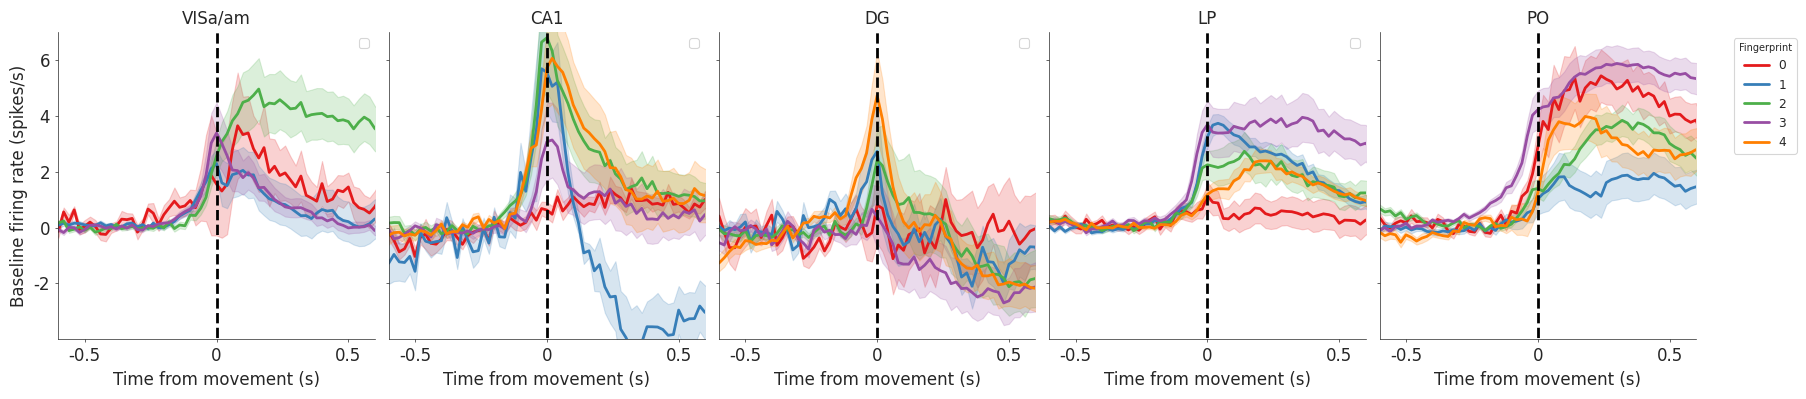

In [147]:
iterations = 50

merged_meta = metadata_repro.merge(mouse_cluster[['mouse_name', 'mouse_cluster']], 
                                on='mouse_name')
df = df_long.Time
    merged_meta = metadata_repro.merge(mouse_cluster[['mouse_name', 'mouse_cluster', 'shuffled_cluster']], 
                                    on='mouse_name')
    df = df_long.merge(merged_meta, on='pid')
    
    # plot_per_area(df, 'shuffled_cluster')
    var = fingerprint_snr(df, 'shuffled_cluster')
    var['iter'] = i
    shuffled_var = pd.concat([shuffled_var, var])
    

(-0.1, 1.0)

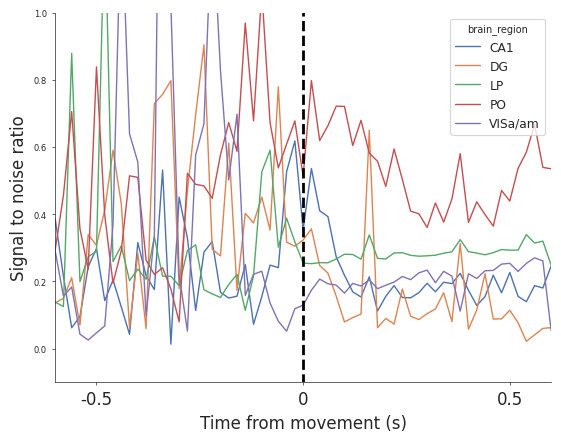

In [148]:
sns.lineplot(x='time', y='snr', hue='brain_region', data=joint_var)
plt.vlines(50, -5, 12, color='black', linestyle='dashed', linewidth=2)
# plt.xticks([0, 50, 100], [-1, 0, 1], size=12)
plt.xticks([25, 50, 75], [-.5, 0, .5], size=12)
# plt.yticks([0, 1, 2, 3], [0, 1, 2, 3], size=12)

plt.ylabel('Signal to noise ratio', size=12)
plt.xlabel('Time from movement (s)', size=12)
plt.xlim([20, 80])
plt.ylim([-.1, 1])


(-0.1, 1.0)

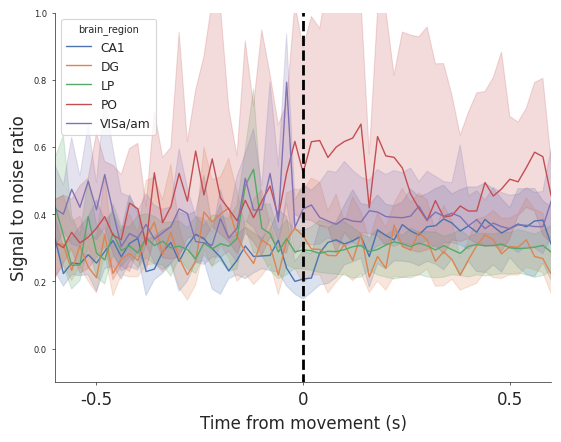

In [149]:
sns.lineplot(x='time', y='snr', hue='brain_region', data=shuffled_var, estimator='median')
plt.vlines(50, -5, 12, color='black', linestyle='dashed', linewidth=2)
# plt.xticks([0, 50, 100], [-1, 0, 1], size=12)
plt.xticks([25, 50, 75], [-.5, 0, .5], size=12)
# plt.yticks([0, 1, 2, 3], [0, 1, 2, 3], size=12)

plt.ylabel('Signal to noise ratio', size=12)
plt.xlabel('Time from movement (s)', size=12)
plt.xlim([20, 80])
plt.ylim([-.1, 1])


In [53]:
def fingerprint_snr(df):

    # mean per mouse
    mu_fm = (df.groupby(["mouse_cluster", "mouse_name", "time", "brain_region"])["firing_rate"].mean().reset_index())

    # numerator: variance across fingerprints
    mu_f = mu_fm.groupby(["mouse_cluster", "time", "brain_region"])["firing_rate"].mean()
    var_across = np.var(mu_f, ddof=1)

    # denominator: mean variance across mice within fingerprint
    var_within = (mu_fm.groupby(["mouse_cluster", "time", "brain_region"])["firing_rate"].var(ddof=1).mean())

    return var_across / var_within

## Averaged per trial type / mode

### Trial mode

In [16]:
metadata_df = bwm_df.copy()
metadata_df = metadata_df.rename(columns={'subject':'mouse_name'})
metadata_repro = metadata_df.loc[metadata_df['pid'].isin(repro_eid)]

merged_trial = metadata_repro.merge(trial_modes[['eid', 'trial_cluster', 'trial_id']], 
                                   on='eid')

In [17]:
event_type  = 'firstMovement_times'
data_path = prefix + 'representation_learning_variability/Neural data/DATA/PETHS/'

var = 'trial_cluster'

all_cells = pd.DataFrame()
for p, pid in enumerate(list(repro_eid)):
    filename = data_path+pid+'_'+event_type
    try:
        pid_df = pd.read_parquet(filename)
        trial_data = merged_trial.loc[merged_trial['pid']==pid]
        pid_new = pid_df.merge(trial_data[['trial_id', 'pid', var]], on=['trial_id', 'pid'])
        pid_new = pid_new.drop(columns=['pid'])
        cell_summary = pid_new.groupby(['cell_id', 'brain_region', var]).mean().reset_index()
        cell_summary['pid'] = pid
        all_cells = pd.concat([all_cells, cell_summary])
    except:
        print(pid)

e4ce2e94-6fb9-4afe-acbf-6f5a3498602e
b83407f8-8220-46f9-9b90-a4c9f150c572
92822789-608f-44a6-ad64-fe549402b2df
92033a0c-5a14-471b-b131-d43c72ca5d7a
22212d26-a167-45fb-9963-35ecd003e8a2
b2746c16-7152-45a3-a7f0-477985638638
478de1ce-d7e7-4221-9365-2abdc6e88fb6
31f3e083-a324-4b88-b0a4-7788ec37b191
1f3d3fcb-f188-47a2-87e5-ac1db6cf393a
9117969a-3f0d-478b-ad75-98263e3bfacf
bc1602ba-dd6c-4ae4-bcb2-4925e7c8632a
7cbecb3f-6a8a-48e5-a3be-8f7a762b5a04
17d9710a-f292-4226-b033-687d54b6545a
7f3dddf8-637f-47bb-a7b7-e303277b2107
8b7c808f-763b-44c8-b273-63c6afbc6aae
e49f221d-399d-4297-bb7d-2d23cc0e4acc
6e1379e8-3af0-4fc5-8ba8-37d3bb02226b
bf96f6d6-4726-4cfa-804a-bca8f9262721
a3d13b05-bf4d-427a-a2d5-2fe050d603ec
19baa84c-22a5-4589-9cbd-c23f111c054c
84bb830f-b9ff-4e6b-9296-f458fb41d160
ca5764ea-a57e-49de-8156-84da18ad439f
730770d6-617a-4ada-95db-a48521befda5
a12c8ae8-d5ad-4d15-b805-436ad23e5ad1
ae252f7b-0224-4925-8174-7b25c2385bb7
dc50c3de-5d84-4408-9725-22ae55b93522
1f5d62cb-814f-4ab2-b6af-7557ea04d56a
9

In [18]:
# all_cells = all_cells.drop(columns='trial_id')
df_long = (all_cells.reset_index().melt(
                id_vars=["cell_id", "brain_region", "pid", var],
                var_name="time",
                value_name="firing_rate"))

df_long = df_long.loc[(df_long['time']!='index') & (df_long['time']!='trial_id')]
df_long['firing_rate'] = df_long['firing_rate']/0.02
df_long.loc[df_long['brain_region']=='VISa', 'brain_region'] = 'VISa/am'
df_long.loc[df_long['brain_region']=='VISam', 'brain_region'] = 'VISa/am'

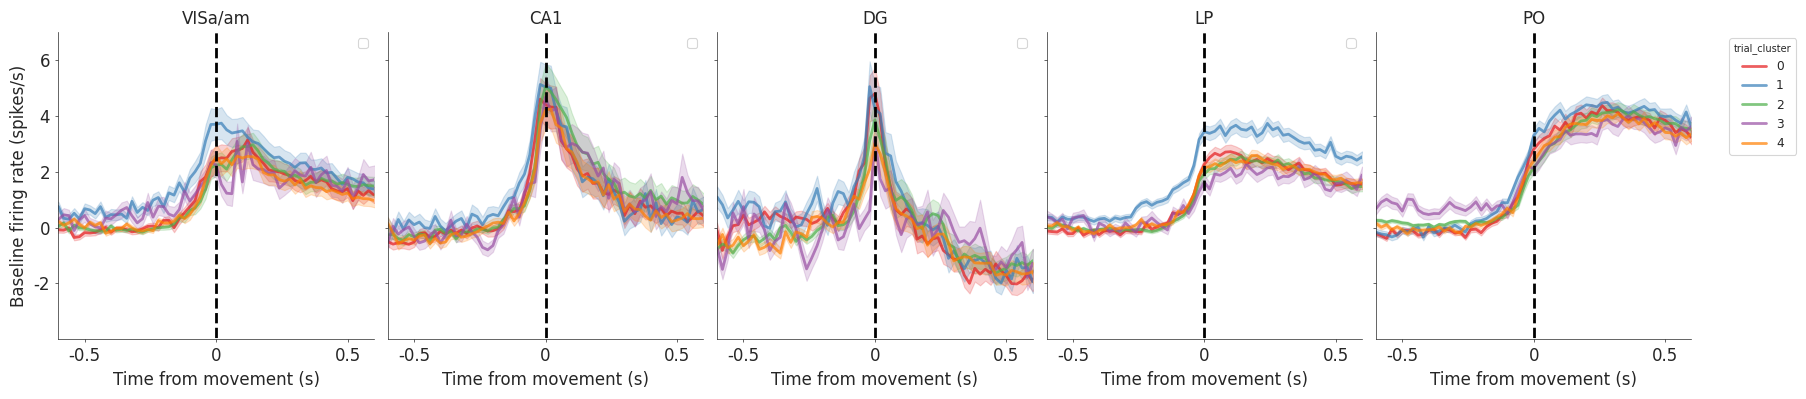

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=[18, 4])
for a, area in enumerate(color_order):
    area_to_plot = df_long.loc[df_long['brain_region']==area]
    sns.lineplot(x='time', y='firing_rate', hue=var, data=area_to_plot, 
             errorbar='se', linewidth=2, alpha=.7,
             palette='Set1', ax=ax[a])  # sns.color_palette("flare", as_cmap=False)
    ax[a].vlines(50, -5, 12, color='black', linestyle='dashed', linewidth=2)
    ax[a].set_xticks([0, 50, 100], [-1, 0, 1], size=12)
    ax[a].set_xticks([25, 50, 75], [-.5, 0, .5], size=12)
    ax[a].set_yticks([-2, 0, 2, 4, 6], [-2, 0, 2, 4, 6], size=12)

    ax[a].set_ylabel('Baseline firing rate (spikes/s)', size=12)
    ax[a].set_xlabel('Time from movement (s)', size=12)
    ax[a].set_ylim([-4, 7])
    ax[a].set_xlim([20, 80])
    ax[a].set_title(area, size=12)
    ax[a].legend('')
ax[a].legend(title=var, loc='upper left', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
#     ax[a].legend()
# ax[5].legend

In [ ]:

metadata_df = bwm_df.copy()
metadata_df = metadata_df.rename(columns={'subject':'mouse_name'})
metadata_repro = metadata_df.loc[metadata_df['pid'].isin(repro_eid)]

merged_meta = metadata_repro.merge(mouse_cluster[['mouse_name', 'mouse_cluster']], 
                                   on='mouse_name')
merged_trial = merged_meta.merge(trials_df, on=['eid', 'mouse_name'])

In [180]:
event_type  = 'firstMovement_times'
data_path = prefix + 'representation_learning_variability/Neural data/DATA/PETHS/'

var = 'choice'

all_cells = pd.DataFrame()
for p, pid in enumerate(list(repro_eid)):
    filename = data_path+pid+'_'+event_type
    try:
        pid_df = pd.read_parquet(filename)
        trial_data = merged_trial.loc[merged_trial['pid']==pid]
        pid_new = pid_df.merge(trial_data[['trial_id', 'pid', var]], on=['trial_id', 'pid'])
        pid_new = pid_new.drop(columns=['pid'])
        cell_summary = pid_new.groupby(['cell_id', 'brain_region', var]).mean().reset_index()
        cell_summary['pid'] = pid
        all_cells = pd.concat([all_cells, cell_summary])
    except:
        print(pid)

e4ce2e94-6fb9-4afe-acbf-6f5a3498602e
b83407f8-8220-46f9-9b90-a4c9f150c572
92822789-608f-44a6-ad64-fe549402b2df
92033a0c-5a14-471b-b131-d43c72ca5d7a
22212d26-a167-45fb-9963-35ecd003e8a2
b2746c16-7152-45a3-a7f0-477985638638
478de1ce-d7e7-4221-9365-2abdc6e88fb6
31f3e083-a324-4b88-b0a4-7788ec37b191
1f3d3fcb-f188-47a2-87e5-ac1db6cf393a
9117969a-3f0d-478b-ad75-98263e3bfacf
bc1602ba-dd6c-4ae4-bcb2-4925e7c8632a
7cbecb3f-6a8a-48e5-a3be-8f7a762b5a04
17d9710a-f292-4226-b033-687d54b6545a
7f3dddf8-637f-47bb-a7b7-e303277b2107
8b7c808f-763b-44c8-b273-63c6afbc6aae
e49f221d-399d-4297-bb7d-2d23cc0e4acc
6e1379e8-3af0-4fc5-8ba8-37d3bb02226b
bf96f6d6-4726-4cfa-804a-bca8f9262721
a3d13b05-bf4d-427a-a2d5-2fe050d603ec
19baa84c-22a5-4589-9cbd-c23f111c054c
84bb830f-b9ff-4e6b-9296-f458fb41d160
ca5764ea-a57e-49de-8156-84da18ad439f
730770d6-617a-4ada-95db-a48521befda5
a12c8ae8-d5ad-4d15-b805-436ad23e5ad1
ae252f7b-0224-4925-8174-7b25c2385bb7
dc50c3de-5d84-4408-9725-22ae55b93522
1f5d62cb-814f-4ab2-b6af-7557ea04d56a
9

In [181]:
# all_cells = all_cells.drop(columns='trial_id')
df_long = (all_cells.reset_index().melt(
                id_vars=["cell_id", "brain_region", "pid", var],
                var_name="time",
                value_name="firing_rate"))

df_long = df_long.loc[(df_long['time']!='index') & (df_long['time']!='trial_id')]
df_long['firing_rate'] = df_long['firing_rate']/0.02
df_long.loc[df_long['brain_region']=='VISa', 'brain_region'] = 'VISa/am'
df_long.loc[df_long['brain_region']=='VISam', 'brain_region'] = 'VISa/am'

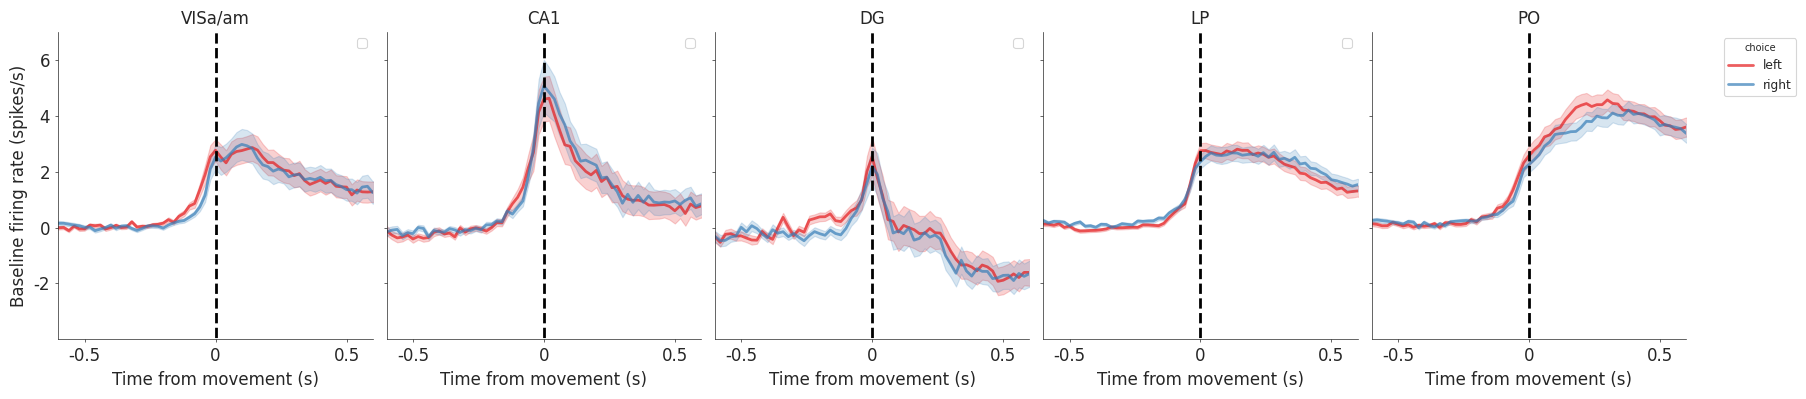

In [182]:
fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=[18, 4])
for a, area in enumerate(color_order):
    area_to_plot = df_long.loc[df_long['brain_region']==area]
    sns.lineplot(x='time', y='firing_rate', hue=var, data=area_to_plot, 
             errorbar='se', linewidth=2, alpha=.7,
             palette='Set1', ax=ax[a])  # sns.color_palette("flare", as_cmap=False)
    ax[a].vlines(50, -5, 12, color='black', linestyle='dashed', linewidth=2)
    ax[a].set_xticks([0, 50, 100], [-1, 0, 1], size=12)
    ax[a].set_xticks([25, 50, 75], [-.5, 0, .5], size=12)
    ax[a].set_yticks([-2, 0, 2, 4, 6], [-2, 0, 2, 4, 6], size=12)

    ax[a].set_ylabel('Baseline firing rate (spikes/s)', size=12)
    ax[a].set_xlabel('Time from movement (s)', size=12)
    ax[a].set_ylim([-4, 7])
    ax[a].set_xlim([20, 80])
    ax[a].set_title(area, size=12)
    ax[a].legend('')
ax[a].legend(title=var, loc='upper left', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
#     ax[a].legend()
# ax[5].legend

In [183]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
mouse_cluster = pd.read_parquet(data_path+'5_mouse_cluster_coef')

In [184]:
metadata_df = bwm_df.copy()
metadata_df = metadata_df.rename(columns={'subject':'mouse_name'})
metadata_repro = metadata_df.loc[metadata_df['pid'].isin(repro_eid)]

merged_meta = metadata_repro.merge(mouse_cluster[['mouse_name', 'mouse_cluster']], 
                                   on='mouse_name')
to_plot = df_long.merge(merged_meta, on='pid')

/tmp/ipykernel_5816/265864196.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='time', y='firing_rate', hue=var, data=area_finger,


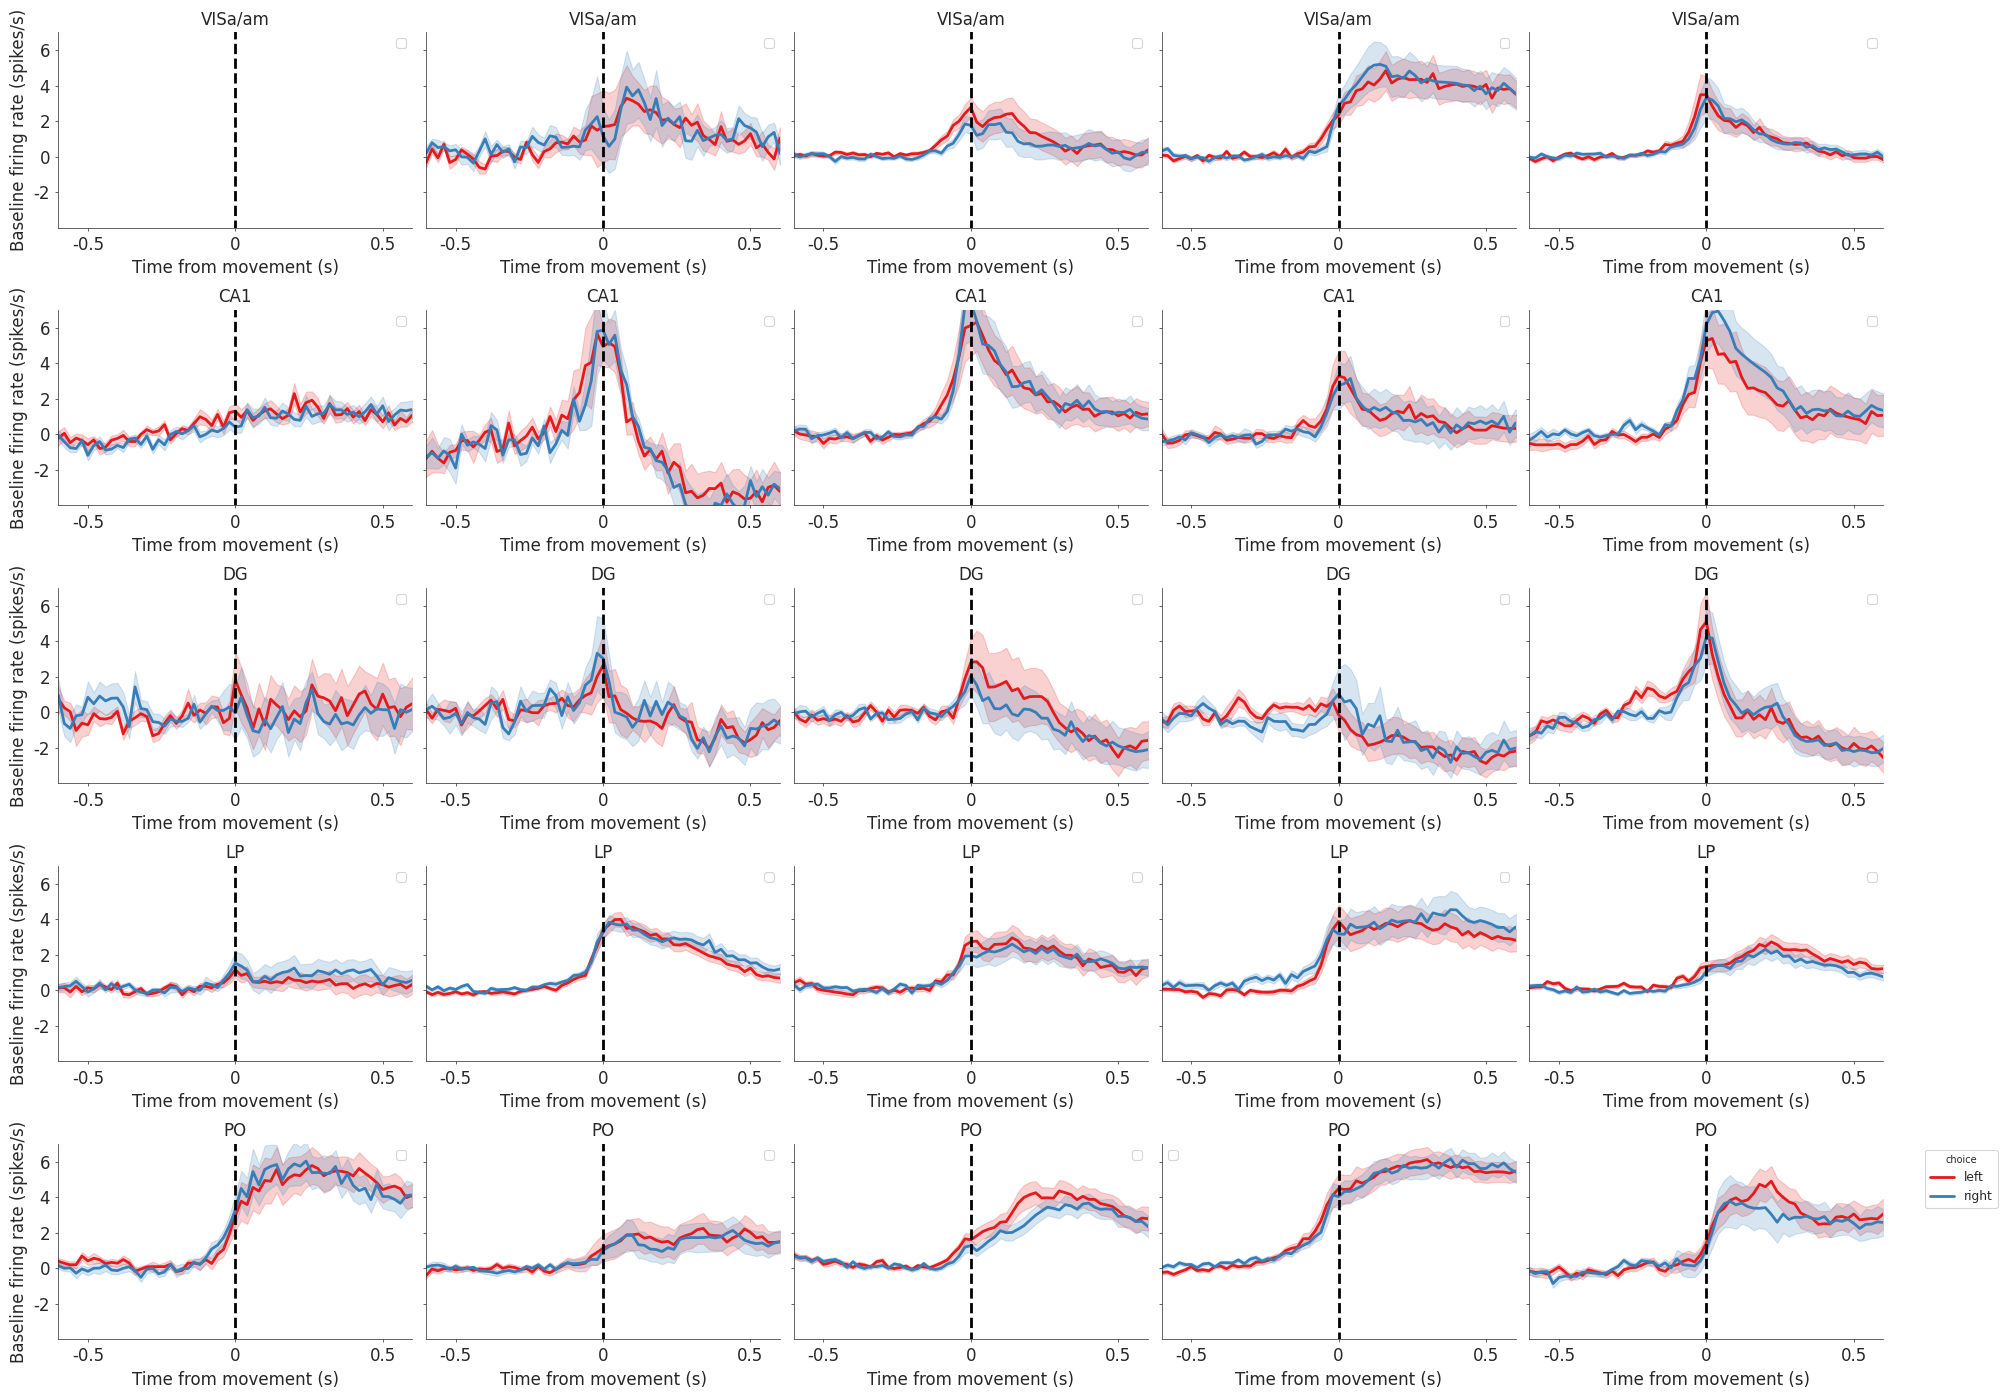

In [185]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharey=True, figsize=[20, 14])
for a, area in enumerate(color_order):
    area_to_plot = to_plot.loc[to_plot['brain_region']==area]
    for f, fingerprint in enumerate([0, 1, 2, 3, 4]):
        area_finger = area_to_plot.loc[area_to_plot['mouse_cluster']==fingerprint]
        sns.lineplot(x='time', y='firing_rate', hue=var, data=area_finger, 
                errorbar='se', linewidth=2, palette='Set1', ax=ax[a, f])  # sns.color_palette("flare", as_cmap=False)
        ax[a, f].vlines(50, -5, 12, color='black', linestyle='dashed', linewidth=2)
        ax[a, f].set_xticks([0, 50, 100], [-1, 0, 1], size=12)
        ax[a, f].set_xticks([25, 50, 75], [-.5, 0, .5], size=12)
        ax[a, f].set_yticks([-2, 0, 2, 4, 6], [-2, 0, 2, 4, 6], size=12)

        ax[a, f].set_ylabel('Baseline firing rate (spikes/s)', size=12)
        ax[a, f].set_xlabel('Time from movement (s)', size=12)
        ax[a, f].set_ylim([-4, 7])
        ax[a, f].set_xlim([20, 80])
        ax[a, f].set_title(area, size=12)
        ax[a, f].legend('')
ax[a, f].legend(title=var, loc='upper left', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
#     ax[a].legend()
# ax[5].legend